# Predição de ativos da bolsa de valores

# Importa as bibliotecas

In [1]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import datetime
from pmdarima.arima import auto_arima # biblioteca que importa o arima
import pmdarima.arima as pm # biblioteca que importa o arima
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import pandas as pd

from pandas_datareader import data 
import yfinance as yfin
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [2]:
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, MaxPooling1D, Activation, MaxPooling1D, Dropout, Flatten, BatchNormalization, GRU, AveragePooling1D, SpatialDropout1D, GlobalAveragePooling1D
#from tensorflow.keras.initializers import he_uniform
from tensorflow import keras

## Análise e visualização de ativos

### Carrega Dados

In [3]:
yfin.pdr_override()

acoes=['B3SA3','PETR4']
peso_acoes=np.ones(len(acoes))*1/len(acoes)
# adc o .SA no nome de cada ação para carregar no banco de dados
for i in range(np.size(acoes)):
    acoes[i]=acoes[i]+".SA"

acoes.append('^BVSP') # inclui o índice ibovespa na ultima coluna

acoes_df = pd.DataFrame() 
for acao in acoes:
     acoes_df[acao] = data.DataReader(acao, start='2010-01-01')['Close']

# substitui o .SA do nome de cada ação para visualização dos dados
for i in range(np.size(acoes)):
    acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('.SA', '')})

#renomeia o índice IBOVESPA para IBOV   
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})
                           
#soma todos os valores nulos
acoes_df.isnull().sum()

#Verifica como está o shape do dataframe
acoes_df.shape
 


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3705, 3)

<Axes: ylabel='Date'>

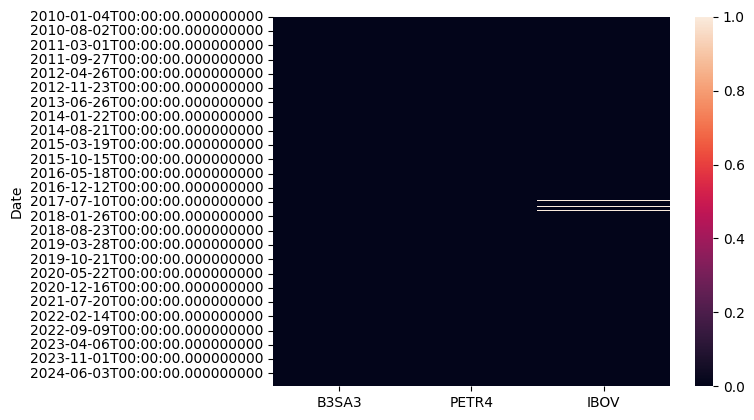

In [4]:
sns.heatmap(acoes_df.isnull())

In [5]:
#apaga registros nulos
acoes_df.dropna(inplace=True)
acoes_df.to_csv('acoes.csv')
acoes_df

,B3SA3,PETR4,IBOV
Date,,,
2010-01-04,12.95,37.320000,70045.000000
2010-01-05,13.00,37.000000,70240.000000
2010-01-06,13.49,37.500000,70729.000000
2010-01-07,13.81,37.150002,70451.000000
2010-01-08,13.49,36.950001,70263.000000
...,...,...,...
2024-11-27,9.76,38.990002,127669.000000
2024-11-28,9.15,38.590000,124610.000000
2024-11-29,9.26,38.900002,125668.000000


### Visualização dos dados 

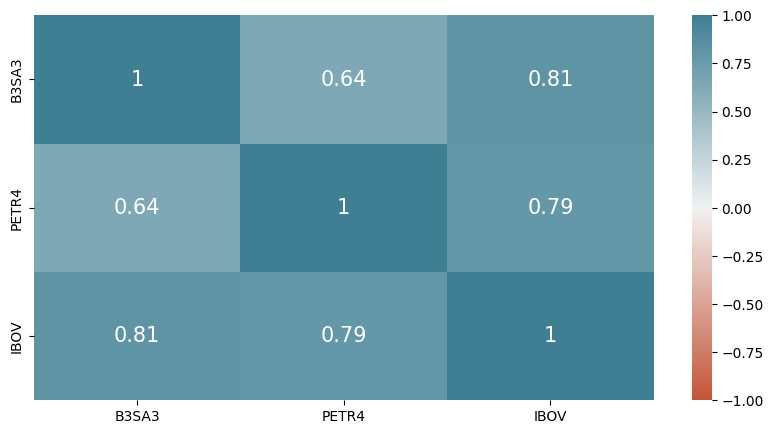

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(10,5))

columns=acoes_df.columns
corrmat = acoes_df[columns].corr()
mask= np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corrmat,
            vmax=1, vmin=-1,
            annot=True, annot_kws={'fontsize':15},
            cmap=sns.diverging_palette(20,220,as_cmap=True))
plt.show()

In [7]:
# Normaliza os dados
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [8]:
acoes_df_normalized

,B3SA3,PETR4,IBOV
Date,,,
2010-01-04,1.000000,1.000000,1.000000
2010-01-05,1.003861,0.991426,1.002784
2010-01-06,1.041699,1.004823,1.009765
2010-01-07,1.066409,0.995445,1.005796
2010-01-08,1.041699,0.990086,1.003112
...,...,...,...
2024-11-27,0.753668,1.044748,1.822671
2024-11-28,0.706564,1.034030,1.778999
2024-11-29,0.715058,1.042337,1.794104


In [9]:
#%% Carregando dados
acoes_df=pd.read_csv('acoes.csv')
acoes_df['Date']=pd.to_datetime(acoes_df['Date'])
acoes_df=acoes_df.set_index('Date')
for col in acoes_df.columns:
    acoes_df[col]=acoes_df[col].astype('float32')

In [10]:
acoes_df_normalized = acoes_df / acoes_df.iloc[0].values

In [11]:
# Cria um gráfico de linha usando o Plotly
fig = go.Figure()
for stocks in acoes_df.columns:
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['IBOV'], mode='lines', name='Preço do Ibovespa'))
#fig.add_trace(go.Scatter(x=acoes_df.index, y=acoes_df['B3SA3'], mode='lines', name='Preço do B3SA3'))
    fig.add_trace(go.Scatter(x=acoes_df_normalized.index, y=acoes_df_normalized[stocks], mode='lines', name=f'Preço do {acoes}'))

# Configura o layout do gráfico
fig.update_layout(
    title='Preço do Ibovespa e ações',
    xaxis_title='Data',
    yaxis_title='Preço',
    showlegend=True
)

# Exibe o gráfico
fig.show()

## Indicadores de tendência e Séries Temporais 

Os swing traders geralmente utilizam médias móveis exponenciais (EMAs) de diferentes períodos para identificar tendências e sinais de compra e venda. As EMAs mais utilizadas pelos swing traders incluem:

-EMA de 9 períodos: A EMA de 9 períodos é comumente usada para identificar sinais de curto prazo e capturar movimentos rápidos do mercado. Pode fornecer sinais mais sensíveis e frequentes.

-EMA de 20 períodos: A EMA de 20 períodos é amplamente utilizada e considerada uma média móvel de curto prazo. É usada para identificar a direção da tendência de curto prazo e possíveis pontos de reversão.

-EMA de 50 períodos: A EMA de 50 períodos é frequentemente usada para identificar a direção da tendência de médio prazo. É uma média móvel amplamente observada pelos swing traders.

-EMA de 100 períodos: A EMA de 100 períodos é usada para identificar a direção da tendência de médio a longo prazo. É útil para identificar pontos de entrada e saída em operações de swing trading mais prolongadas.

-EMA de 200 períodos: A EMA de 200 períodos é uma das médias móveis mais amplamente observadas e é usada para identificar a direção da tendência de longo prazo. É frequentemente usada como um indicador-chave para determinar a tendência geral do mercado.

In [12]:
acoes_df = acoes_df.rename(columns={acoes[i]:acoes[i].replace('^BVSP', 'IBOV')})


In [13]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import plotly.graph_objects as go

# Define o código de ticker da ação
ticker = "^BVSP" # ibovespa
ticker = "B3SA3"


if ticker!="^BVSP":
    ticker=ticker+".SA"

# Obtém os dados históricos da ação
df = data.DataReader(ticker, start='2015-01-01')

df.columns

[*********************100%%**********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [14]:
df['Close'].values

array([3.17000008, 3.08333302, 3.11333299, ..., 9.26000023, 9.36999989,
       9.46000004])

In [15]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)b
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [16]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['EMA9'], mode='lines', name='EMA9'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA20'], mode='lines', name='EMA20'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA50'], mode='lines', name='EMA50'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA100'], mode='lines', name='EMA100'))
fig.add_trace(go.Scatter(x=df.index, y=df['EMA200'], mode='lines', name='EMA200'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA111*2'], mode='lines', name='MA111*2'))
fig.add_trace(go.Scatter(x=df.index, y=df['MA350*2'], mode='lines', name='MA350*2'))

if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [17]:
# Cria um gráfico de candlestick usando o Plotly
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick')])

# Adiciona as médias móveis ao gráfico
fig.add_trace(go.Scatter(x=df.index, y=df['upper_band_bollinger'], mode='lines', name='upper band bollinger'))
fig.add_trace(go.Scatter(x=df.index, y=df['lower_band_bollinger'], mode='lines', name='lower band bollinger'))


if ticker=="^BVSP":
    ticker='IBOV'

# Configura o layout do gráfico
fig.update_layout(
    width=1500,
    height=700,
    title=f"Gráfico de Candlestick e Médias Móveis para {ticker}",
    xaxis_title="Data",
    yaxis_title="Preço",
    showlegend=True
)

# Exibe o gráfico
fig.show()


In [18]:

# Calcular a variação percentual entre o preço de fechamento de um dia e o dia seguinte
df['Variation'] = ((df['Close'] - df['Close'].shift(+1)) / df['Close'])*100
#pred_data_df['Variacao'] = ((pred_data_df['pred']-pred_data_df['pred'].shift(+1)) / pred_data_df['pred'])*100


# Thresholds for variation classification
positive_threshold = 0.03
negative_threshold = -0.03

# Create a new column for classified variation
df['Classification'] = df['Variation'].apply(lambda x: 
                                            1 if x > positive_threshold else (
                                                -1 if x < negative_threshold else 0))

#df['week']=df.index.week
df['weekday']=df.index.weekday+1
df['day']=df.index.day
df['month']=df.index.month
df['quarter']=df.index.quarter

df=df.reset_index().fillna(0)
df


,Date,Open,High,Low,Close,Adj Close,Volume,upper_band_bollinger,lower_band_bollinger,EMA9,...,MA350*2,RSI_14,MACD,Signal,Variation,Classification,weekday,day,month,quarter
0,2015-01-02,3.270000,3.270000,3.150000,3.170000,2.179621,21734100,0.000000,0.000000,3.170000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,5,2,1,1
1,2015-01-05,3.143333,3.153333,3.056666,3.083333,2.120032,34790100,0.000000,0.000000,3.121852,...,0.000000,0.000000,-0.006914,-0.001383,-2.810824,-1,1,5,1,1
2,2015-01-06,3.066666,3.113333,3.033333,3.113333,2.140659,49214700,0.000000,0.000000,3.118360,...,0.000000,0.000000,-0.009858,-0.003078,0.963597,1,2,6,1,1
3,2015-01-07,3.133333,3.283333,3.126666,3.236666,2.225461,24006600,0.000000,0.000000,3.158437,...,0.000000,0.000000,-0.002215,-0.002905,3.810494,1,3,7,1,1
4,2015-01-08,3.296666,3.300000,3.190000,3.193333,2.195665,22967700,0.000000,0.000000,3.168818,...,0.000000,0.000000,0.000343,-0.002256,-1.356985,-1,4,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465,2024-11-27,10.130000,10.190000,9.760000,9.760000,9.760000,57603000,11.072564,9.633436,10.074130,...,24.426571,25.506131,-0.245532,-0.224980,-4.303279,-1,3,27,11,4
2466,2024-11-28,9.770000,9.820000,9.150000,9.150000,9.150000,65340600,11.132040,9.405960,9.889304,...,24.396800,22.826146,-0.306008,-0.241186,-6.666674,-1,4,28,11,4
2467,2024-11-29,9.200000,9.340000,8.990000,9.260000,9.260000,81908200,11.131018,9.254982,9.763443,...,24.369257,24.199348,-0.341127,-0.261174,1.187912,1,5,29,11,4
2468,2024-12-02,9.200000,9.420000,9.140000,9.370000,9.370000,78340300,11.114188,9.146813,9.684754,...,24.343200,31.349241,-0.355980,-0.280135,1.173956,1,1,2,12,4


## Data preprocessing to stock forecast

### Pré-processamento dos dados para predição 

In [19]:
ticker

'B3SA3.SA'

In [20]:
df=data.DataReader(acoes, start='2015-01-01')['Close']
df

[*********************100%%**********************]  3 of 3 completed


,B3SA3.SA,PETR4.SA,^BVSP
Date,,,
2015-01-02,3.170000,9.360000,48512.000000
2015-01-05,3.083333,8.560000,47517.000000
2015-01-06,3.113333,8.280000,48001.000000
2015-01-07,3.236666,8.670000,49463.000000
2015-01-08,3.193333,9.230000,49943.000000
...,...,...,...
2024-11-27,9.760000,38.990002,127669.000000
2024-11-28,9.150000,38.590000,124610.000000
2024-11-29,9.260000,38.900002,125668.000000


In [21]:
### Using all selected stokcs to AI database 
df=data.DataReader(acoes, start='2015-01-01')['Close']
df = pd.melt(df.reset_index(),id_vars='Date',var_name='Ação', value_name='Valor') 

df.rename(columns={'Valor': 'Close'}, inplace=True)
df

[*********************100%%**********************]  3 of 3 completed


,Date,Ação,Close
0,2015-01-02,B3SA3.SA,3.170000
1,2015-01-05,B3SA3.SA,3.083333
2,2015-01-06,B3SA3.SA,3.113333
3,2015-01-07,B3SA3.SA,3.236666
4,2015-01-08,B3SA3.SA,3.193333
...,...,...,...
7405,2024-11-27,^BVSP,127669.000000
7406,2024-11-28,^BVSP,124610.000000
7407,2024-11-29,^BVSP,125668.000000
7408,2024-12-02,^BVSP,125236.000000


In [22]:
scaler = MinMaxScaler()
y=scaler.fit_transform(df['Close'].values.reshape(-1,1))

# Function to compute Simple Moving Average (SMA)b
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# Function to compute Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute Moving Average Convergence Divergence (MACD)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, min_periods=1, adjust=False).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(data, window=20, num_std=2):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return upper_band, lower_band

df['upper_band_bollinger'],df['lower_band_bollinger']=calculate_bollinger_bands(df)
# Calcula as EMAs de 9 e 20 períodos
df['EMA9'] = df['Close'].ewm(span=9).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
df['EMA50'] = df['Close'].ewm(span=50).mean()
df['EMA100'] = df['Close'].ewm(span=100).mean()
df['EMA200'] = df['Close'].ewm(span=200).mean()
df['MA111*2'] = df['Close'].rolling(window=111).mean() * 2
df['MA350*2'] = df['Close'].rolling(window=350).mean() * 2


# Calculate RSI (14-period)
df['RSI_14'] = calculate_rsi(df, window=14)

# Calculate RSI (21-period)
df['RSI_21'] = calculate_rsi(df, window=21)

# Calculate MACD (12, 26, 9)
df['MACD'], df['Signal'] = calculate_macd(df, short_window=12, long_window=26, signal_window=9)


In [23]:
data_array.ata_array.reshape(5, 4)

NameError: name 'data_array' is not defined

In [ ]:
data_array= np.nan_to_num(df.iloc[:,2:].values.astype(np.float32))
# Reshape the numpy array to 5x4
image_array = data_array.reshape(5, 4)

ValueError: cannot reshape array of size 97482 into shape (5,4)

In [ ]:
# Visualize the image
plt.imshow(image_array, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import StandardScaler

X = d[d.columns[0:20]]
Y = d['labeldd']

# TRANSFORMING DATA
scaler = StandardScaler()
X = scaler.fit_transform(X)

#SPLITTING THE DATA
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

#REPLACING THE nan VALUE WITH THE MEAN OF X_TRAIN, X_TEST
X_train = np.nan_to_num(X_train, nan=X_train.mean())
X_test = np.nan_to_num(X_test, nan=X_test.mean())
X_a = np.array(X_train)
X_b = np.array(X_test)

NameError: name 'd' is not defined